In [1]:
import nibabel as nib
import numpy as np
from nilearn import datasets,maskers, plotting,image,connectome
from bids.layout import BIDSLayout

In [2]:
#base directory
fmriprep_dir='../Full-Dataset'
layout=BIDSLayout(fmriprep_dir)

In [3]:
len(layout.get_subjects())

71

In [5]:
# Fetch the AAL atlas
aal_atlas = datasets.fetch_atlas_aal('SPM12')

# Load the AAL atlas image
aal_img = nib.load(aal_atlas.maps)

In [18]:
aal_img.shape

(91, 109, 91)

In [19]:
len(aal_atlas.indices)

116

In [7]:
# Assuming you have an fMRI image 'fmri_img', load it using nibabel
fmri_img = nib.load(r'C:\Users\reub\Downloads\exmni_filtered_func_data.nii.gz')

# Extract data from the fMRI image
fmri_data = fmri_img.get_fdata()
fmri_data.shape

(91, 109, 91, 336)

In [8]:
# Create an array to store the ROI data
roi_data = np.zeros((len(aal_atlas.labels), fmri_data.shape[-1]))

In [9]:
roi_mask = (aal_img.get_fdata() == 2001)
roi_mask
roi_data=fmri_data[roi_mask]
len(roi_data)

3526

In [10]:
# # Iterate through each region in the AAL atlas
# for i, label in enumerate(aal_atlas.labels):
#     # Get the region ID corresponding to the label
#     region_id = int(aal_atlas.indices[i])

#     # Mask the fMRI data with the region's binary mask from the atlas
#     roi_mask = (aal_img.get_fdata() == region_id)
#     roi_data[i, :] = np.mean(fmri_data[roi_mask], axis=0)

# # Now, 'roi_data' contains the mean time series for each ROI

# # Optionally, you can also obtain the coordinates of each ROI
# roi_coordinates = np.array([np.where(aal_img_resampled.get_fdata() == int(aal_atlas.indices[i])) for i in range(len(aal_atlas.labels))])

In [11]:
n=0
# Iterate through each region in the AAL atlas
for i, label in enumerate(aal_atlas.labels):
    # Get the region ID corresponding to the label
    region_id = int(aal_atlas.indices[i])

    # Mask the fMRI data with the region's binary mask from the atlas
    roi_mask = (aal_img.get_fdata() == region_id)
    roi_data = fmri_data[roi_mask]
    if roi_data.shape[0]<=100:
        n+=1
        print(label)
print(n)

# Now, 'roi_data' contains the mean time series for each ROI

# Optionally, you can also obtain the coordinates of each ROI
# roi_coordinates = np.array([np.where(aal_img_resampled.get_fdata() == int(aal_atlas.indices[i])) for i in range(len(aal_atlas.labels))])

Vermis_1_2
1


In [20]:
def extract_mean_time_series(roi_data,s):
    # Extract mean time series from a random one-third of voxels in the ROI
    
    num_voxels = roi_data.shape[0]
    num_selected_voxels = num_voxels // 3
    # Perform bootstrapping by sampling with replacement
    np.random.seed(s)
    selected_voxels_index = np.random.choice(len(roi_data), size=num_selected_voxels,replace=False)
    extracted_data = np.array([roi_data[idx] for idx in selected_voxels_index])
    mean_time_series = np.mean(extracted_data, axis=0)
    return mean_time_series

In [21]:
def data_augmentation(fmri_files,no_of_augmentations):
    all_sub_aug_t=[]
    all_sub_aug_corr=[]
    for f in fmri_files:
        # Assuming you have an fMRI image 'fmri_img', load it using nibabel
        fmri_img = nib.load(f)
        # Extract data from the fMRI image
        fmri_data = fmri_img.get_fdata()
        for s in range(no_of_augmentations):
            augmented_time_sample=[]
            # Iterate through each region in the AAL atlas
            for i, label in enumerate(aal_atlas.labels):
                # Get the region ID corresponding to the label
                region_id = int(aal_atlas.indices[i])
                # Mask the fMRI data with the region's binary mask from the atlas
                roi_mask = (aal_img.get_fdata() == region_id)
                roi_data = fmri_data[roi_mask]
                mean_t_s=extract_mean_time_series(roi_data,s)
                augmented_time_sample.append(mean_t_s)
            sub_aug_ts=np.array(augmented_time_sample)
            sub_aug_corr=np.corrcoef(sub_aug_ts)
            all_sub_aug_t.append(sub_aug_ts)
            all_sub_aug_corr.append(sub_aug_corr)
    all_sub_aug_corr=np.array(all_sub_aug_corr)
    all_sub_aug_t=np.array(all_sub_aug_t)
    return all_sub_aug_corr,all_sub_aug_t

In [22]:
fmriprep_dir='../Full-Dataset'
layout=BIDSLayout(fmriprep_dir)
# Fetch the AAL atlas
aal_atlas = datasets.fetch_atlas_aal('SPM12')
# Load the AAL atlas image
aal_img = nib.load(aal_atlas.maps)

print(f'Number of labels in the atlas: {len(aal_atlas.labels)}\n')

subject_labels = layout.get_subjects()

fmri_files=[]
for subject_label in subject_labels:
    file_name=f'../Full-Dataset/MNI_fitted_Fmri/sub-{subject_label}_exmni.nii.gz'
    fmri_files.append(file_name)

print(f'Number of Subjects in the Dataset:{len(fmri_files)}\n')

Number of labels in the atlas: 116

Number of Subjects in the Dataset:71



In [31]:
all_sub_aug_corr,all_sub_aug_t=data_augmentation(fmri_files,10)

In [33]:
all_sub_aug_corr.shape
#all_sub_aug_t.shape

(710, 116, 116)

In [25]:
np.save('../source_data/fc/augmented_fc_matrices_10',all_sub_aug_corr)
np.save('../source_data/time_series/augmented_time_series_10',all_sub_aug_t)

In [2]:
subject_fc_matrices=np.load('../source_data/fc/augmented_fc_matrices_10.npy')
subject_time_series=np.load('../source_data/time_series/augmented_time_series_10.npy')

In [3]:
subject_fc_matrices.shape

(710, 116, 116)

In [15]:
subject_fc_matrices[15]==subject_fc_matrices[12]

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

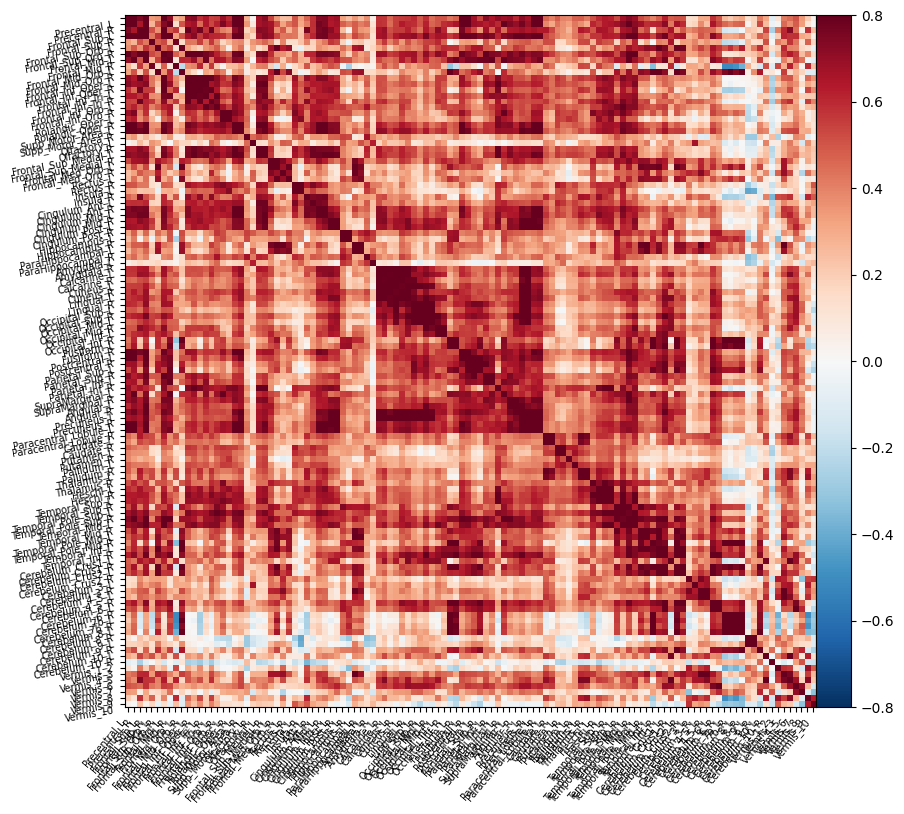

In [13]:
plotting.plot_matrix(subject_fc_matrices[15], figure=(10, 8), labels=aal_atlas.labels,
                     vmax=0.8, vmin=-0.8);

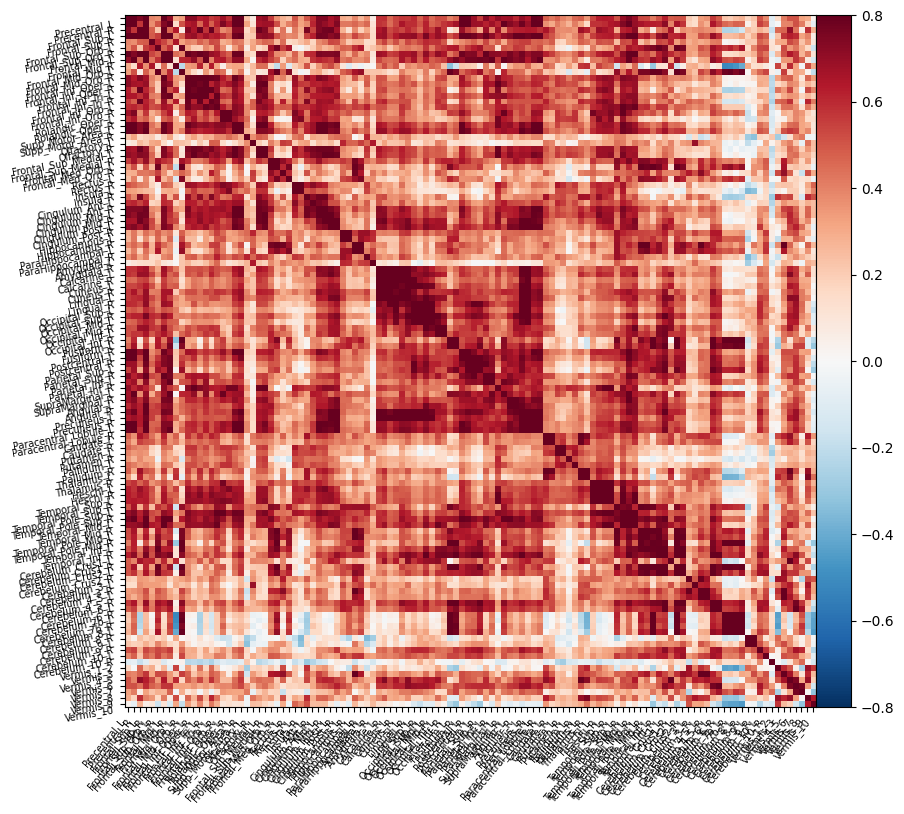

In [14]:
plotting.plot_matrix(subject_fc_matrices[12], figure=(10, 8), labels=aal_atlas.labels,
                     vmax=0.8, vmin=-0.8);

In [43]:
(all_sub_aug_corr[0],all_sub_aug_corr[1])

(array([[ 1.        ,  0.83581652,  0.60119122, ..., -0.1923339 ,
         -0.02708919, -0.03008906],
        [ 0.83581652,  1.        ,  0.55791746, ..., -0.15918404,
         -0.08866728, -0.05932157],
        [ 0.60119122,  0.55791746,  1.        , ..., -0.0035176 ,
          0.03961542, -0.06902491],
        ...,
        [-0.1923339 , -0.15918404, -0.0035176 , ...,  1.        ,
          0.37167403,  0.39584145],
        [-0.02708919, -0.08866728,  0.03961542, ...,  0.37167403,
          1.        ,  0.62880982],
        [-0.03008906, -0.05932157, -0.06902491, ...,  0.39584145,
          0.62880982,  1.        ]]),
 array([[ 1.        ,  0.83101096,  0.56397837, ..., -0.20862362,
         -0.04473297, -0.03600071],
        [ 0.83101096,  1.        ,  0.52590582, ..., -0.16007769,
         -0.0915525 , -0.0464739 ],
        [ 0.56397837,  0.52590582,  1.        , ...,  0.0130944 ,
          0.05211237, -0.05403463],
        ...,
        [-0.20862362, -0.16007769,  0.0130944 , ...,  